# Word vectors from scratch
- read the text
- preprocess the text
- create data points
- create one-hot encoded matrices
- train neural network
- extract weights from the input layer

In [38]:
sentences = [
    "Dogs and cats are pets.",
    "Dogs are canine.",
    "Cats are feline.",
    "A dog is a man's best friend.",
    "A gecko can be a pet.",
    "Cats are such fickle creatures.",
    "A gecko is a reptile.",
    "Dogs and wolves are distant cousins.",
    "Dogs and cats can be found in a house.",
    "Wolves are wild."
    "Dogs, cats, and wolves are mammals.",
    "Mammals are warm-blooded.",
    "A wolf is a mammal.",
    "A gecko is a lizard.",
    "A lizard is cold-blooded.",
    "Reptiles are cold-blooded.",
    "Wolves are found in the forest.",
    "The gecko lives in a house.",
    "Wolves are canine.",
    "Dogs and wolves are canine."
    "A cat is a mammal.",
]

In [55]:
sentences = [
"The future king is the prince",
"Daughter is the princess",
"Son is the prince",
"Only a man can be a king",
"Only a woman can be a queen",
"The princess will be a queen",
"Queen and king rule the realm",
"The prince is a strong man",
"The princess is a beautiful woman",
"The royal family is the king and queen and their children",
"Prince is only a boy now",
"A boy will be a man",
]

In [56]:
import re
from typing import List, Tuple


def clean_text(
    text: str,
    punctuations: str = r"""!()-[]{};:'"\,<>./?@#$%^&*_~""",
    stop_words: List = ["the", "a", "and", "is", "are", "in", "be", "can"],
) -> str:
    # Removing the punctuations
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [57]:
def create_word_pairs(text: List[str], window: int = 2) -> List[List[str]]:
    word_pairs = []
    for idx, word in enumerate(text):
        for w in range(window):
            if idx + 1 + w < len(text):
                pair = tuple([word] + [text[idx + 1 + w]])
                word_pairs.append(pair)
            if idx - w - 1 >= 0:
                pair = tuple([word] + [text[idx - w - 1]])
                word_pairs.append(pair)    
    return word_pairs

Let's then get the unique words for each and store them:

In [58]:
all_text = [clean_text(sentence).split() for sentence in sentences]
unique_words = sorted(set([word for text in all_text for word in text]))

Let's create one-hot encoded vectors for each word

In [59]:
def one_hot_encode(pairs: List[Tuple[str, str]], vocab: List[str]):
    n_words = len(vocab)
    
    # Create X and Y matrices
    X = []
    Y = []
    
    
    for pair in pairs:
        
        # Get main and context words
        main, ctx = pair  
        main_idx = vocab.index(main)
        ctx_idx = vocab.index(ctx)
        
        # Perform one-hot encoding
        x_row = [0] * n_words
        x_row[main_idx] = 1 
        X.append(x_row)
        y_row = [0] * n_words
        y_row[ctx_idx] = 1
        Y.append(y_row)
        
    return X, Y

In [60]:
all_word_pairs = []
for text in all_text:
    all_word_pairs += create_word_pairs(text)
#word_pairs = [create_word_pairs(text) for text in all_text]

In [61]:
all_word_pairs

[('future', 'king'),
 ('future', 'prince'),
 ('king', 'prince'),
 ('king', 'future'),
 ('prince', 'king'),
 ('prince', 'future'),
 ('daughter', 'princess'),
 ('princess', 'daughter'),
 ('son', 'prince'),
 ('prince', 'son'),
 ('only', 'man'),
 ('only', 'king'),
 ('man', 'king'),
 ('man', 'only'),
 ('king', 'man'),
 ('king', 'only'),
 ('only', 'woman'),
 ('only', 'queen'),
 ('woman', 'queen'),
 ('woman', 'only'),
 ('queen', 'woman'),
 ('queen', 'only'),
 ('princess', 'will'),
 ('princess', 'queen'),
 ('will', 'queen'),
 ('will', 'princess'),
 ('queen', 'will'),
 ('queen', 'princess'),
 ('queen', 'king'),
 ('queen', 'rule'),
 ('king', 'rule'),
 ('king', 'queen'),
 ('king', 'realm'),
 ('rule', 'realm'),
 ('rule', 'king'),
 ('rule', 'queen'),
 ('realm', 'rule'),
 ('realm', 'king'),
 ('prince', 'strong'),
 ('prince', 'man'),
 ('strong', 'man'),
 ('strong', 'prince'),
 ('man', 'strong'),
 ('man', 'prince'),
 ('princess', 'beautiful'),
 ('princess', 'woman'),
 ('beautiful', 'woman'),
 ('beauti

In [62]:
X, y = one_hot_encode(pairs=all_word_pairs, vocab=unique_words)

Define our model

In [63]:
import torch
import torch.optim as optim
from torch import nn

In [64]:
input_dim, hidden_dim, output_dim = len(X[0]), 2, len(y[0])
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Linear(hidden_dim, output_dim),
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Convert our inputs and outputs into tensors
X_t = torch.FloatTensor(X)
y_t = torch.FloatTensor(y)

Train the model

In [65]:
for t in range(int(10e3)):
    # Compute forward pass and print loss
    y_pred = model(X_t)
    loss = loss_fn(y_pred, torch.argmax(y_t, dim=1))  # doesn't take one-hot encoded
    
    if t % 1000 == 999:
        print(t, loss.item())
    
    # Zero the gradients before running the backward pass
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update weights using gradient descent
    optimizer.step()

999 3.055026054382324
1999 2.931213855743408
2999 2.832176923751831
3999 2.7551655769348145
4999 2.693279504776001
5999 2.6408722400665283
6999 2.5932226181030273
7999 2.5490612983703613
8999 2.5083606243133545
9999 2.470337152481079


In [66]:
name, weights = list(model.named_parameters())[0]

In [67]:
w = weights.data.tolist()

In [68]:
# Create embedding dict

embedding_dict = {}
for idx, word in enumerate(unique_words):
    embedding_dict[word] = (w[0][idx], w[1][idx])

In [69]:
embedding_dict

{'beautiful': (0.8477770686149597, 0.7542559504508972),
 'boy': (-0.31998804211616516, -1.0173211097717285),
 'children': (-0.28870347142219543, 0.7289250493049622),
 'daughter': (1.1857783794403076, 0.7064486145973206),
 'family': (0.30006468296051025, 0.3182021379470825),
 'future': (0.6042844653129578, 0.13751676678657532),
 'king': (-0.9287204146385193, 0.03452605381608009),
 'man': (0.8867284655570984, -0.7220445275306702),
 'now': (0.8684091567993164, -0.8846240043640137),
 'only': (0.27370283007621765, -0.5859041810035706),
 'prince': (0.2048516869544983, -0.6950091123580933),
 'princess': (0.29105421900749207, -0.6662549376487732),
 'queen': (0.02048061229288578, 0.8370211720466614),
 'realm': (-0.19176338613033295, 0.8194845914840698),
 'royal': (-0.02828543446958065, 1.2688241004943848),
 'rule': (0.26983606815338135, 0.9086438417434692),
 'son': (-0.10500167310237885, -0.8579081892967224),
 'strong': (-0.5024044513702393, -1.2159572839736938),
 'their': (0.9739663600921631, 

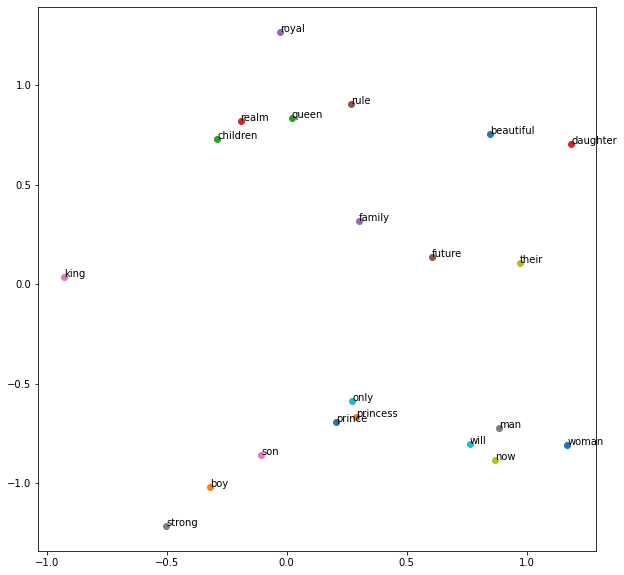

In [70]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for word in unique_words:
    coord = embedding_dict[word]
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, coord)
    